### Imports

In [29]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

### Data load

In [13]:
data_path_train = "data/df_train.csv"

df_train = pd.read_csv(data_path_train)
df_train = df_train.drop(columns=['BsmtHalfBath', 'PoolQC_Fa', 'Utilities_NoSeWa', 'PoolQC_Gd', 'BsmtFinSF2'])  # low correlation features

df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.000000,20.000000,50.000000,70.000000,190.000000
MSZoning,1460.0,181782.263881,22935.777066,127035.234484,190160.409288,191083.315173,191233.328298,212190.396173
LotFrontage,1460.0,57.623288,34.664304,0.000000,42.000000,63.000000,79.000000,313.000000
LotArea,1460.0,10516.828082,9981.264932,1300.000000,7553.500000,9478.500000,11601.500000,215245.000000
LotConfig,1460.0,180684.289342,10273.395580,171965.477367,176192.888970,177369.498778,178489.289614,222245.584865
...,...,...,...,...,...,...,...,...
Fence_MnPrv,1460.0,0.107534,0.309897,0.000000,0.000000,0.000000,0.000000,1.000000
Fence_MnWw,1460.0,0.007534,0.086502,0.000000,0.000000,0.000000,0.000000,1.000000
MiscFeature_Othr,1460.0,0.001370,0.036999,0.000000,0.000000,0.000000,0.000000,1.000000
MiscFeature_Shed,1460.0,0.033562,0.180160,0.000000,0.000000,0.000000,0.000000,1.000000


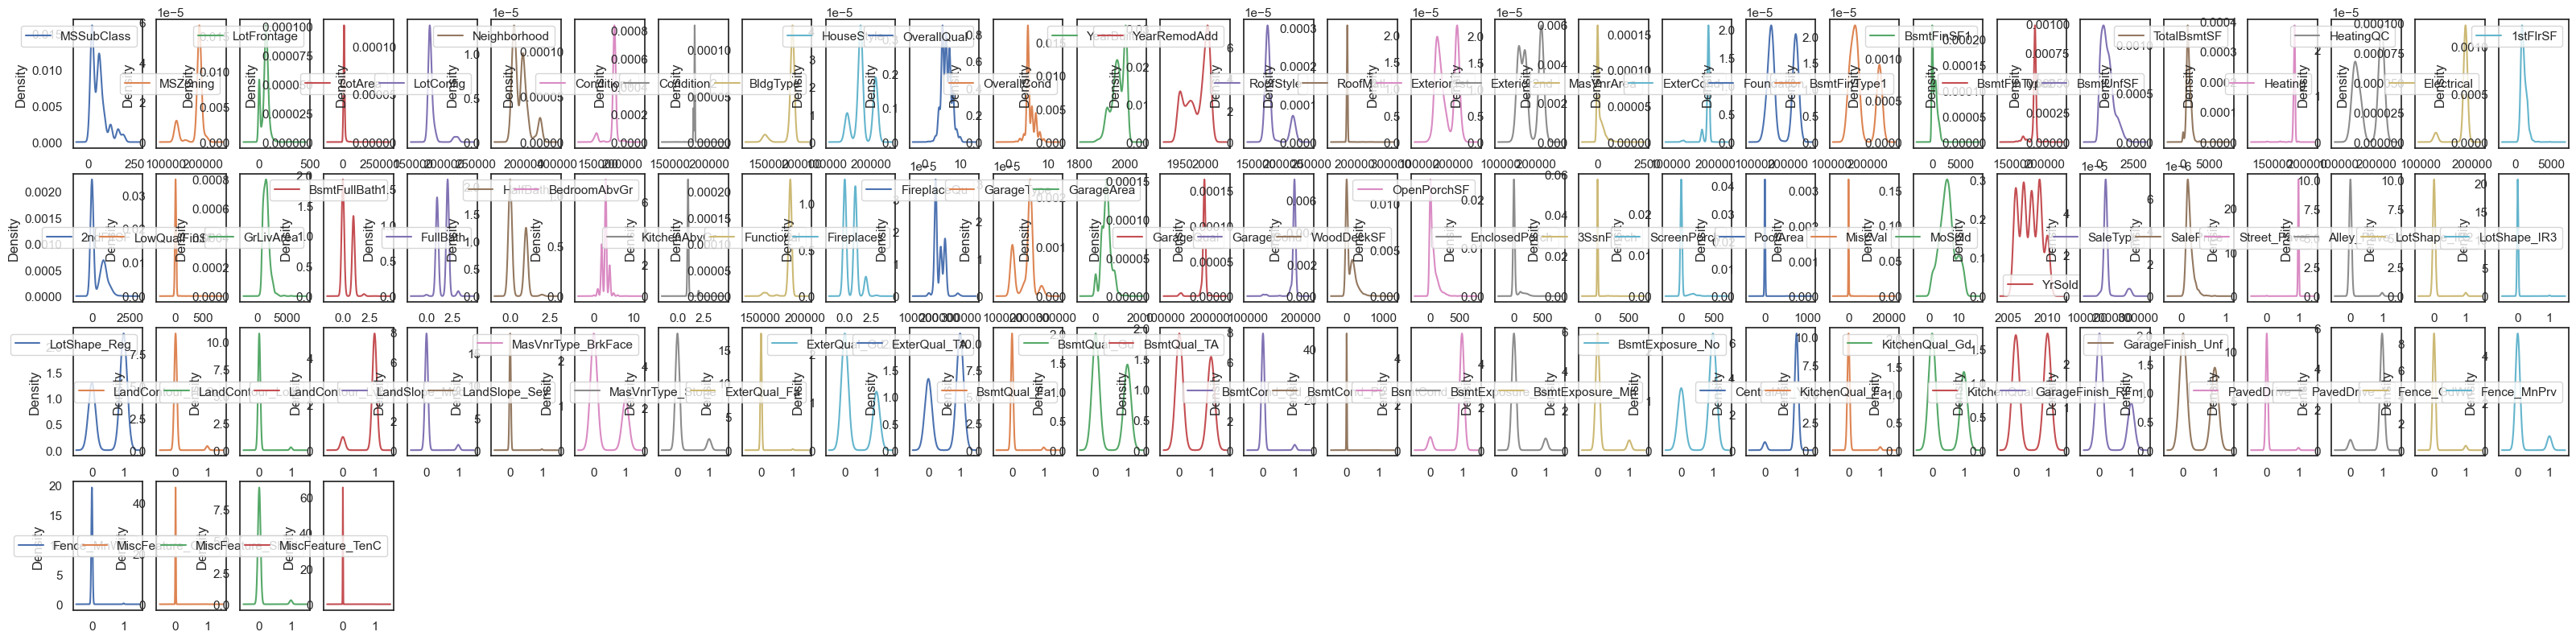

In [14]:
df_train.plot(kind='density', subplots=True, layout=(40,30), sharex=False, figsize= (40,99))
plt.show()

In [36]:
TARGET = "SalePrice"

X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Feature selection

In [37]:
feature_selector = SelectKBest(
    score_func=f_regression,
    k=40 # selecting top 40 features
)

### Ridge Regression

In [38]:
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", feature_selector),
    ("model", Ridge())
])

ridge_params = {
    "feature_selection__k": [30, 40, 50],
    "model__alpha": [0.1, 1.0, 10.0]
}

### Random Forest

In [39]:
rf_pipeline = Pipeline([
    ("feature_selection", feature_selector),
    ("model", RandomForestRegressor(random_state=42))
])

rf_params = {
    "feature_selection__k": [30, 40],
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 3, 5]
}

### Gradient Boosting

In [40]:
gbr_pipeline = Pipeline([
    ("feature_selection", feature_selector),
    ("model", GradientBoostingRegressor(random_state=42))
])

gbr_params = {
    "feature_selection__k": [30, 40],
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4]
}

### XGBoost

In [41]:
xgb_pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_regression)),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    ))
])

xgb_params = {
    "feature_selection__k": [30, 40, 50],
    "model__n_estimators": [500, 800],
    "model__max_depth": [3, 4, 6],
    "model__learning_rate": [0.03, 0.05],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_alpha": [0.0, 0.1],
    "model__reg_lambda": [1.0, 1.5]
}

### Training & Hyperparameter Search

In [42]:
models = {
    "Ridge": (ridge_pipeline, ridge_params),
    "RandomForest": (rf_pipeline, rf_params),
    "GradientBoosting": (gbr_pipeline, gbr_params),
    "XGBoost": (xgb_pipeline, xgb_params)
}

results = {}

In [43]:
for name, (pipeline, params) in models.items():
    print(f"\nTraining {name}...")

    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)

    results[name] = {
        "best_params": grid.best_params_,
        "MAE": mean_absolute_error(y_val, y_pred),
        "RMSE": root_mean_squared_error(y_val, y_pred),
        "R2": r2_score(y_val, y_pred)
    }


Training Ridge...

Training RandomForest...

Training GradientBoosting...

Training XGBoost...


##### Feature Importance

In [47]:
best_rf = results["RandomForest"]

rf_best_model = models["RandomForest"][0].set_params(**results["RandomForest"]["best_params"])
rf_best_model.fit(X_train, y_train)

selected_features = X.columns[
    rf_best_model.named_steps["feature_selection"].get_support()
]

importances = rf_best_model.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": selected_features,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

In [48]:
feature_importance_df

,feature,importance
0,OverallQual,0.508749
1,GrLivArea,0.114363
2,Neighborhood,0.106434
3,1stFlrSF,0.036177
4,2ndFlrSF,0.034581
5,TotalBsmtSF,0.033749
6,BsmtFinSF1,0.031723
7,GarageArea,0.019998
8,LotArea,0.016677
9,YearBuilt,0.009732


#### Results Comparison

In [50]:
results_df = pd.DataFrame(results).T.sort_values("MAE")
results_df

,best_params,MAE,RMSE,R2
XGBoost,"{'feature_selection__k': 40, 'model__colsample...",17020.345703,25723.949219,0.91373
GradientBoosting,"{'feature_selection__k': 40, 'model__learning_...",17269.908709,26767.476432,0.906588
RandomForest,"{'feature_selection__k': 40, 'model__max_depth...",17685.347979,28709.762776,0.89254
Ridge,"{'feature_selection__k': 50, 'model__alpha': 1...",19207.930382,32082.482235,0.865809


House prices are in the $100k–$500k range

Best model is XGBoost

R² = 0.9137 

MAE ≈ $17k 

RMSE ≈ $25.7k